In [ ]:
%load_ext autoreload
%autoreload 2
import os
from copy import deepcopy
from os.path import join as oj

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from tqdm import tqdm
import sys
sys.path.append('..')
sys.path.append('../projection_manipulation')
import transects

import data
import util
from matching import *
from config import *

df = data.load_all_labs()
df = df.set_index('fname_id')

# get fnames
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f] # these start at 00001
fname_ids = np.array([f[:-4] for f in fname_nps])

## calculating / loading dists

In [2]:
'''
# load the linear models in latent space
coefs, intercepts = transects.get_directions()
coefs = np.array(coefs).squeeze()
intercepts = np.array(intercepts)

# load latents and calculate gan dists
print('loading latents...')
latents = np.array([np.load(oj(DIR_GEN, f)) for f in fname_nps])
lats = get_lat(latents)
preds = latents.mean(axis=1) @ coefs.T + intercepts.T
weights = np.zeros(preds.shape[1])
# print(ATTR_TO_INDEX)
# weights[ATTR_TO_INDEX['skin-color']] = 1e2
vecs = join_vecs(preds, lats, weights)
dists_gan = calc_dists_from_latents(vecs)
print(dists_gan.shape)
np.save(open(oj(DIR_PROCESSED, 'dists_pairwise_gan.npy'), 'wb'), dists_gan)
print('done!')
'''

"\n# load the linear models in latent space\ncoefs, intercepts = transects.get_directions()\ncoefs = np.array(coefs).squeeze()\nintercepts = np.array(intercepts)\n\n# load latents and calculate gan dists\nprint('loading latents...')\nlatents = np.array([np.load(oj(DIR_GEN, f)) for f in fname_nps])\nlats = get_lat(latents)\npreds = latents.mean(axis=1) @ coefs.T + intercepts.T\nweights = np.zeros(preds.shape[1])\n# print(ATTR_TO_INDEX)\n# weights[ATTR_TO_INDEX['skin-color']] = 1e2\nvecs = join_vecs(preds, lats, weights)\ndists_gan = calc_dists_from_latents(vecs)\nprint(dists_gan.shape)\nnp.save(open(oj(DIR_PROCESSED, 'dists_pairwise_gan.npy'), 'wb'), dists_gan)\nprint('done!')\n"

In [17]:
dists_gan = data.get_dists('gan')
dists_facial = data.get_dists('facial')
dists_vgg = data.get_dists('vgg')

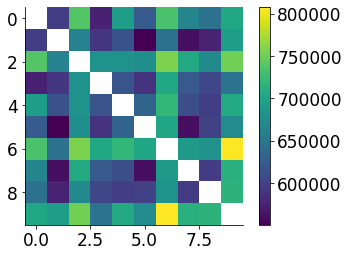

In [18]:
plt.imshow(dists_vgg[:10, :10])
plt.colorbar()

# do matching

### find matching for an im

In [ ]:
dists = dists_facial
N_MATCHES_TO_PLOT = 5

for im_idx in range(10):# range(38, 45):
    
    # select subset of indices to use for matching
    idxs = np.ones(df.shape[0]).astype(bool)
#     idxs = (df['gender'] > 0).values
#     idxs = (df['race'] == 'Black').values
#     idxs = (df['Eyeglasses'] > 0).values
    dists_im = dists[im_idx][idxs] # first select row, then select vals
    fname_ids_for_matching = fname_ids[idxs]    
    closest_match_vals, closest_matches_fnames = calc_matches(dists_im, fname_ids_for_matching)
    
    # load images
    fname_id = fname_ids[im_idx]
    im_orig = mpimg.imread(oj(DIR_IMS, f'{fname_id}.jpg'))
    im_rec = mpimg.imread(oj(DIR_GEN, f'{fname_id}.png'))
    im_matches = [mpimg.imread(oj(DIR_GEN, f'{fname_match}.png'))
                  for fname_match in closest_matches_fnames[:N_MATCHES_TO_PLOT]]
    
    # plt images
    util.plot_row([im_orig, im_rec] + im_matches,
                  annot_list=['orig', 'rec'] + closest_match_vals[:N_MATCHES_TO_PLOT].round(3).tolist(), dpi=150)
    plt.show()

**match many dist types**

In [ ]:
dists = dists_vgg
N_MATCHES_TO_PLOT = 8
im_idx = 0
for dists, dist_name in zip([dists_gan, dists_facial, dists_vgg],
                            ['GAN', 'Facial-rec', 'Perceptual']):
    
    # select subset of indices to use for matching
    idxs = np.ones(df.shape[0]).astype(bool)
    dists_im = dists[im_idx][idxs] # first select row, then select vals
    fname_ids_for_matching = fname_ids[idxs]    
    closest_match_vals, closest_matches_fnames = calc_matches(dists_im, fname_ids_for_matching)
    
    # load images
    fname_id = fname_ids[im_idx]
    im_orig = mpimg.imread(oj(DIR_IMS, f'{fname_id}.jpg'))
    im_rec = mpimg.imread(oj(DIR_GEN, f'{fname_id}.png'))
    im_matches = [mpimg.imread(oj(DIR_GEN, f'{fname_match}.png'))
                  for fname_match in closest_matches_fnames[:N_MATCHES_TO_PLOT]]
    dist0 = closest_match_vals[0]
    util.plot_row([im_orig] + im_matches,
                  annot_list=['Original'] + [f'Dist {d/dist0: 0.3f}' for d in 
                                             closest_match_vals[:N_MATCHES_TO_PLOT]],
                  ylab=dist_name,
                  dpi=150)
    util.savefig('dist_' + dist_name.lower().replace(' ', '_'))
    plt.show()

**simple dim reduction**

In [ ]:
def plot_image(xs, ys, im):
    '''Note: should normalize x/y coords to 0-1 before plotting
    '''
    for idx, (x, y) in tqdm(enumerate(zip(xs, ys))):
        bb = Bbox.from_bounds(x, y, IM_SIZE, IM_SIZE)  
        bb2 = TransformedBbox(bb, ax.transData)
        bbox_image = BboxImage(bb2, origin=None, clip_on=False)
        bbox_image.set_data(im[idx])
#          bbox_image.set_alpha(1.0)
        ax.add_artist(bbox_image)
    return ax

# plot
N_IMS = 1000
IM_SIZE = 0.025
N_PLOT = 1000

fig = plt.figure(figsize=(20, 20), dpi=100)
ax = fig.add_subplot(111)
ims = [mpimg.imread(oj(DIR_IMS, f))[::2, ::2] for f in df.fname_final[:N_IMS]]
l = sklearn.decomposition.PCA(n_components=2).fit_transform(lats[:N_IMS])
# l = sklearn.manifold.TSNE().fit_transform(lats[:N_IMS])
l = (l - l.min(axis=0)) / (l.max(axis=0) - l.min(axis=0))
ax = plot_image(l[:N_PLOT, 0], l[:N_PLOT, 1], ims)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
# plt.xlim((0.5, 1))
# plt.ylim((0, 0.5))
plt.show()

# plots for specific ids/matches

**make some plots for a specific match**

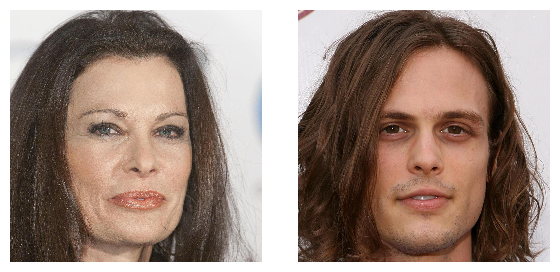

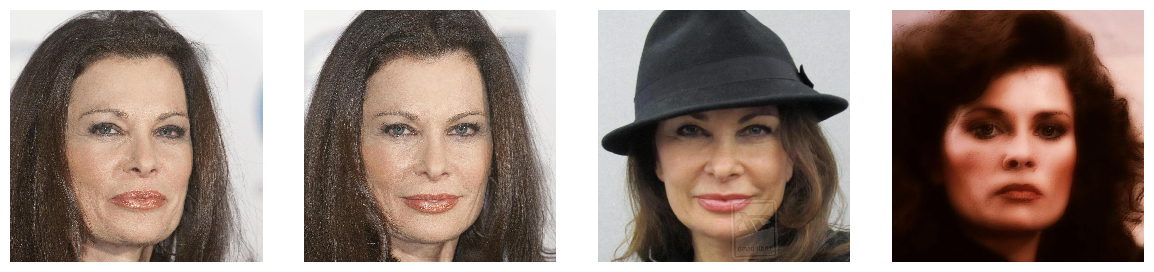

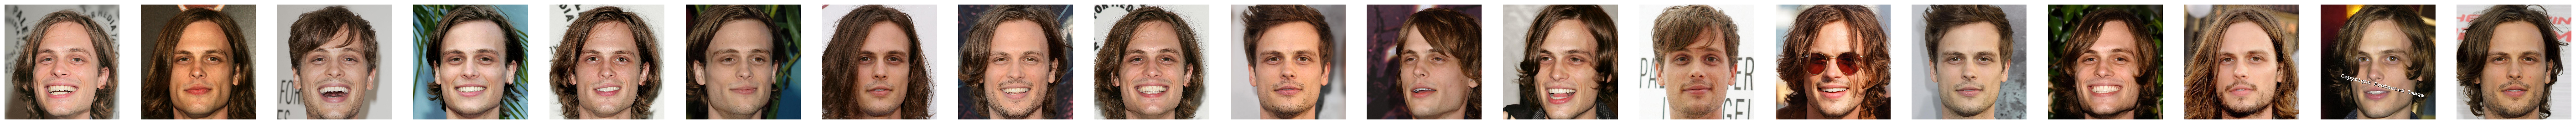

In [19]:
im_idx = 38 # img 38 is a good gender example
fname_id2 = '02638' # this is the match
# if all images are calculated, then this is just 5-char string of im_idx + 1
fname_id = fname_ids[im_idx] 


# idxs
im = mpimg.imread(oj(DIR_IMS, f'{fname_id}.jpg'))
im2 = mpimg.imread(oj(DIR_IMS, f'{fname_id2}.jpg'))

d1 = df[df.id == df.loc[fname_id].id]
d2 = df[df.id == df.loc[fname_id2].id]



util.plot_row([im, im2])
util.plot_row([mpimg.imread(oj(DIR_IMS, f)) for f in d1.fname_final])
util.plot_row([mpimg.imread(oj(DIR_IMS, f)) for f in d2.fname_final])

**look at images / reconstructions of the same person**

In [ ]:
d = df[df['count_with_this_id'] >= df['count_with_this_id'].max() - 1]
dd = d[d.id == d.iloc[0].id]
util.plot_row([mpimg.imread(oj(DIR_IMS, f)) for f in dd.fname_final][:5])
util.plot_row([mpimg.imread(oj(DIR_GEN, f'{index}.png')) for index in dd.index][:5])

## relationships between different dists

In [3]:
dists_facial = data.get_dists('facial')

In [15]:
from scipy.stats import spearmanr

0.7931316375622193 0.8232508660296333
0.8048117100760447 0.859060314203589
0.8606563946506801 0.8585830798014851
0.877861093925158 0.8890211496016713
0.8414389857912447 0.8522161452471597
0.8503410377429004 0.8755570203372304
0.8651729121417767 0.8837213747934556
0.8850989650637414 0.9108220567457538
0.8339022663389037 0.8590557345247137
0.8392359981298971 0.8445957969970771


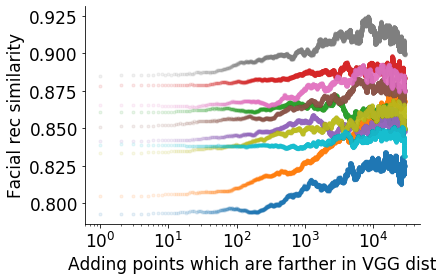

In [42]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

for i in range(10):
    args = np.argsort(dists_ref[i])
    recs = dists_facial[i][args]
    recs = recs[recs != 1e3]
    # print(spearmanr(np.arange(recs.size), recs))
    plt.plot(moving_average(recs, n=1000), '.', alpha=0.1)
    plt.xscale('log')
    
    print(np.mean(recs[:1000]), np.mean(recs[1000:]))
plt.xlabel('Adding points which are farther in VGG dist')
plt.ylabel('Facial rec similarity')
plt.show()

In [ ]:
for i in range(10):
    d0 = dists_ref[i]
    d1 = dists_facial[i]
    legal = (d0 != 1e3) & (d1 != 1e3)
    d0 = d0[legal]
    d1 = d1[legal]
    plt.plot(d0, d1, '.', alpha=0.1)
#     print(spearmanr(d0, d1))
plt.xlabel('VGG dist')
plt.ylabel('Facial rec dist')
plt.show()

In [45]:
# means for facial dists between first 1000 vgg points and the rest (is v significant)
means0 = []
means1 = []
for i in tqdm(range(30000)):
    args = np.argsort(dists_ref[i])
    recs = dists_facial[i][args]
    recs = recs[recs != 1e3]    
    means0.append(np.nanmean(recs[:1000]))
    means1.append(np.nanmean(recs[1000:]))
print(np.nanmean(means0), np.nanstd(means0) / np.sqrt(len(means0)))
print(np.nanmean(means1), np.nanstd(means1) / np.sqrt(len(means1)))

100%|██████████| 30000/30000 [01:22<00:00, 364.43it/s]


# evaluate matching with metrics

**how often do we return the same id?**

In [4]:
dists_match_names = ['facial', 'vgg', 'gan', 'gan_constrained']
d = df[df['count_with_this_id'] > 1]
d = df
d = d[[k for k in d.keys()
       if not ('md5' in k or 'file' in k or 'idx' in k or 'fname' in k or 'prob' in k or 'count_with' in k)]] # filter some keys we don't really care about

N_IMS = 1000
suffs = ['', '_diff']
errs_keys = ['err_top1', 'err_top5', 'err_top10']
numerical_keys = ['yaw', 'pitch', 'roll', 'background_mean', 'background_std', 'quality']
attr_keys = [kk for kk in d.keys() if not 'scores' in kk and not kk in numerical_keys]
all_keys = errs_keys + attr_keys + numerical_keys \
        + [kk + '_diff' for kk in attr_keys + numerical_keys]

In [ ]:
def select_dist(dists_match_name):
    if dists_match_name == 'facial':
        return dists_facial
    elif dists_match_name == 'vgg':
        return dists_vgg
    elif dists_match_name == 'gan':
        return dists_gan
    elif dists_match_name == 'gan_constrained':
        return dists_gan + (dists_facial > 0.6) * 1e3 # constraint for missclassificaiton

In [40]:
r = {
    k: [] for k in all_keys + [kk + '_std' for kk in all_keys]
}

for dists_match_name in dists_match_names:
    dists_match = select_dist(dists_match_name)
    lists = {
        k: [] for k in all_keys
    }
    print('calculating', dists_match_name)
    for im_idx in tqdm(range(N_IMS)):
        orig = d.iloc[im_idx]
        id_orig = orig.id

        # id retention
        dists_im = dists_match[im_idx]
        # these indexes are all in df.space (not d.space)
        matched_idxs = np.argsort(dists_im)
        matched_ids = df.iloc[matched_idxs].id.values
        matched_idxs_diff = matched_idxs[matched_ids[matched_ids != id_orig]]
        
        # to convert back to d, we get the index from df
        matched_df_index = df.iloc[matched_idxs].index.values
        matched_df_index_diff = df.iloc[matched_idxs_diff].index.values
        
        # preserving id
        lists['err_top1'].append(id_orig not in matched_ids[:1])
        lists['err_top5'].append(id_orig not in matched_ids[:5])
        lists['err_top10'].append(id_orig not in matched_ids[:10])
        
        # 2 types of matching
        # d_full = df.iloc[matched_idxs[:10]]
        d_full = df.loc[matched_df_index[:10]]
        d_diff = df.loc[matched_df_index_diff[:10]] # df.iloc[matched_idxs_diff[:10]]
        
        for dd, suff in zip([d_full, d_diff], suffs):
            # binary feats
            for k in attr_keys:
                lists[k + suff].append(np.mean(dd[k] != orig[k]))
            
            # numerical feats
            for k in numerical_keys:
                lists[k + suff].append(np.mean(np.abs(dd[k] - orig[k])))
    
    # condense into one value per key/dist
    for k in lists.keys():
        r[k].append(np.mean(lists[k]))
        r[k + '_std'].append(np.std(lists[k]))
            
r = pd.DataFrame.from_dict(r)
r.N_IMS = N_IMS
r.index = dists_match_names
r.to_pickle('processed/13_dist_stats.pkl')

  0%|          | 2/1000 [00:00<01:24, 11.83it/s]

calculating facial


  0%|          | 2/1000 [00:00<01:14, 13.48it/s]

calculating vgg


  0%|          | 2/1000 [00:00<01:12, 13.86it/s]

calculating gan


  0%|          | 2/1000 [00:00<01:10, 14.20it/s]

calculating gan_constrained


100%|██████████| 1000/1000 [01:10<00:00, 14.27it/s]


# load and view the matches

In [5]:
r = pd.read_pickle('processed/13_dist_stats.pkl').round(3)
for k in all_keys:
    if not k in numerical_keys and not k.replace('_diff', '') in numerical_keys: # or k == 'quality':
        r[k] *= 100
        r[k + '_std'] *= 100
r['quality'] *= 100
# for k in r.keys():
#     if r.loc['gan', k] > r.loc['facial', k]:
#         print(k, f"{r.loc['gan', k] - r.loc['facial', k]:0.1f}")
# r #.round(3).style.background_gradient()
r[[k for k in r.keys() if '_diff' not in k]]

err_top1  err_top5  err_top10    id  gender  hair-length  \
facial                7.8       4.7        4.5  27.4     1.0         13.0   
vgg                   0.2       0.0        0.0  88.4    22.1         17.7   
gan                  80.4      72.4       67.6  94.9    16.0         14.8   
gan_constrained      36.0      16.6       12.3  55.8     0.9         13.0   

                 facial-hair  makeup  skin-color   age  ...  race_pred_std  \
facial                   7.1    25.8         8.4  11.8  ...           18.2   
vgg                     12.7    36.1         5.4  22.8  ...           28.7   
gan                     16.4    30.8         7.1  24.2  ...           29.7   
gan_constrained          7.4    27.2         8.0  13.1  ...           21.4   

                 race4_pred_std  gender_pred_std  age_pred_std  yaw_std  \
facial                     13.8             16.9          31.7    7.913   
vgg                        26.6             19.9          29.3    4.459   
gan                        29.6             23.0          33.3    3.167   
gan_constrained            17.1             16.3          31.4    5.465   

                 pitch_std  roll_std  background_mean_std  background_std_std  \
facial               3.877     1.492               17.949               8.167   
vgg                  3.091     1.109                8.766               9.827   
gan                  3.028     1.145               11.242               5.610   
gan_constrained      3.533     1.311               16.008               7.458   

                 quality_std  
facial                 0.029  
vgg                    0.033  
gan                    0.039  
gan_constrained        0.030  

[4 rows x 120 columns]

In [10]:
r.index = ['Facial-rec dist', 'VGG dist', 'GAN dist', 'Combined']
id_attributes = ['err_top1', 'gender', 'race_pred']
qual_attributes = ['blurry', 'quality']
image_attributes = ['background_mean', 'yaw', 'pitch', 'roll']
id_correlated_attributes = ['mustache', 'eyeglasses', 'bangs', 'wearing_hat']
# attrs = id_attributes + qual_attributes + image_attributes + id_correlated_attributes
attrs = image_attributes + id_attributes

r2 = deepcopy(r).round(1)

# add in stddev
n = r2.shape[0]
for k in r2.keys():
    if not 'std' in k:
        r2[k] = [str(r2[k].values[i]) + ' $\pm$ ' +  str(np.round(r2[k + '_std'].values[i] / np.sqrt(n), 0))
                 for i in range(n)]

        
rename = {
    'err_top1': 'ID (top1)',
    'race_pred': 'Race',
    'background_mean': 'Background Mean',
}
for k in attrs:
    if not k in rename:
        rename[k] = k.capitalize()        
r3 = r2[attrs].rename(columns=rename)

In [16]:
s = r3.loc[['GAN dist', 'Facial-rec dist', 'Combined']].to_latex().replace('textbackslash pm', 'pm').replace('\$', '$')
s = s.replace('llllllll', 'lllll|lll') # add in dividing line
print(s)
# r3

\begin{tabular}{lllll|lll}
\toprule
{} & Background Mean &             Yaw &          Pitch &           Roll &        ID (top1) &           Gender &             Race \\
\midrule
GAN dist        &  33.2 $\pm$ 6.0 &   6.6 $\pm$ 2.0 &  5.6 $\pm$ 2.0 &  1.7 $\pm$ 1.0 &  80.4 $\pm$ 20.0 &  16.0 $\pm$ 11.0 &  36.5 $\pm$ 15.0 \\
Facial-rec dist &  40.3 $\pm$ 9.0 &  13.8 $\pm$ 4.0 &  6.9 $\pm$ 2.0 &  2.3 $\pm$ 1.0 &   7.8 $\pm$ 13.0 &    1.0 $\pm$ 3.0 &    8.2 $\pm$ 9.0 \\
Combined        &  38.9 $\pm$ 8.0 &  10.2 $\pm$ 3.0 &  6.5 $\pm$ 2.0 &  2.0 $\pm$ 1.0 &  36.0 $\pm$ 24.0 &    0.9 $\pm$ 3.0 &  14.8 $\pm$ 11.0 \\
\bottomrule
\end{tabular}



**also look at matches across dists**

In [ ]:
# r_diff = r[[a + '_diff' for a in attrs if f'{a}_diff' in r.keys()]]
# r_diff